In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from torchvision.utils import make_grid

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)

In [3]:
config["operator_params"]["operator"] = "CompressedSensing"
config["operator_params"]["num_measurements"] = 100
config["exp_params"]["batch_size"] = 100

In [4]:
dm = mnist_dataloader_test(config, path=path)
gen = iter(dm)
x, y = next(gen)

/home/mingliang/anaconda3/envs/torch3090/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

In [6]:
show(config)

operator_params
    operator: CompressedSensing
    size: 13
    num_measurements: 100
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: posterior
    potential: mse
base_model_params
    model_name: mnist/vae/vanilla


In [7]:
from torch import nn, Tensor

class Discriminator(nn.Module):

    def __init__(self, config) -> None:
        """
        Args:
            feature_maps: Number of feature maps to use
            image_channels: Number of channels of the images from the dataset
        """
        super().__init__()
        feature_maps = 64
        image_channels = 1

        self.disc = nn.Sequential(
            self._make_disc_block(image_channels, feature_maps, batch_norm=False),
            self._make_disc_block(feature_maps, feature_maps * 2),
            self._make_disc_block(feature_maps * 2, feature_maps * 4),
            self._make_disc_block(feature_maps * 4, feature_maps * 8),
            self._make_disc_block(feature_maps * 8, 1, kernel_size=2, stride=1, padding=0, last_block=True),
        )

    @staticmethod
    def _make_disc_block(
        in_channels: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
        bias: bool = False,
        batch_norm: bool = True,
        last_block: bool = False,
    ) -> nn.Sequential:
        if not last_block:
            disc_block = nn.Sequential(
                torch.nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)),
                nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            disc_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
            )

        return disc_block

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(self.disc(x)).view(-1, 1).squeeze(1)
    
    def logit(self, x: Tensor) -> Tensor:
        return self.disc(x).view(-1, 1).squeeze(1)

In [8]:
config['operator_params']["operator"] = "RandomOcclude"
config['estimator_params']['potential'] = "mse"
config['estimator_params']['estimator'] = "langevin"
config['estimator_params']['mode'] = "importance_avg"
config['estimator_params']['lambda'] = 1
config['estimator_params']['lambda_score'] = 1
config["base_model_params"]["model_name"] = "mnist/vae/vanilla"
config["base_model_params"]["model_name"] = "mnist/vae/vanilla"
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan_spectral"
config["estimator_params"]["noise_factor"] = 0.05
config["estimator_params"]["burn_in"] = 120
config["estimator_params"]["num_steps_finetune"] = 1
config["estimator_params"]["num_samples_for_finetune"] = 10000
config['estimator_params']['initalisation'] = "map_posterior"
config['estimator_params']['num_steps_map_initaliser'] = 100
config['estimator_params']['step_size_map_initaliser'] = 0.1
config['estimator_params']['disc_on'] = True

In [9]:
discriminator = Discriminator(config)
discriminator.load_state_dict(torch.load("non_gan_discriminator.ckpt"))
discriminator.to("cuda")
config["estimator_params"]["discrimiantor"] = lambda z: discriminator(ebm.model.model.model.decoder(z))

In [18]:
ebm = make_energy_model(config, path=path)
x = x.to("cuda")
ebm = ebm.to("cuda")
# The math
x_tilde = ebm.operator(x)
x_hat = ebm(x_tilde)

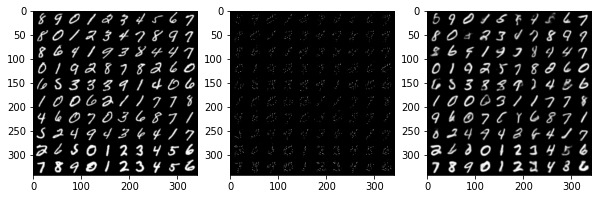

In [19]:
fig, axs = plt.subplots(figsize=(10, 30), nrows = 1, ncols = 3)
grid = make_grid(x, nrow=10).cpu()
axs[0].imshow(rearrange(grid, 'c h w -> h w c'))
grid = make_grid(x_tilde, nrow=10).cpu()
axs[1].imshow(rearrange(grid, 'c h w -> h w c'))
grid = make_grid(x_hat, nrow=10).cpu()
axs[2].imshow(rearrange(grid, 'c h w -> h w c'))

In [12]:
show(config)

operator_params
    operator: RandomOcclude
    size: 13
    num_measurements: 100
estimator_params
    estimator: langevin
    burn_in: 120
    n_samples: 15
    step_size: 0.01
    mode: importance_avg
    initalisation: map_posterior
    potential: mse
    lambda: 1
    lambda_score: 1
    discriminator_base_model: mnist/gan/dcgan_spectral
    noise_factor: 0.05
    num_steps_finetune: 1
    num_samples_for_finetune: 10000
    num_steps_map_initaliser: 100
    step_size_map_initaliser: 0.1
    disc_on: True
    discrimiantor: <function <lambda> at 0x7f58241e9f80>
base_model_params
    model_name: mnist/vae/vanilla


In [13]:
config['estimator_params']['potential'] = "mse"
config['estimator_params']['lambda'] = 1
config["estimator_params"]["noise_factor"] = 0.05
config["estimator_params"]["burn_in"] = 120
config['estimator_params']['on'] = False

In [14]:
show(config)

operator_params
    operator: RandomOcclude
    size: 13
    num_measurements: 100
estimator_params
    estimator: langevin
    burn_in: 120
    n_samples: 15
    step_size: 0.01
    mode: importance_avg
    initalisation: map_posterior
    potential: mse
    lambda: 1
    lambda_score: 1
    discriminator_base_model: mnist/gan/dcgan_spectral
    noise_factor: 0.05
    num_steps_finetune: 1
    num_samples_for_finetune: 10000
    num_steps_map_initaliser: 100
    step_size_map_initaliser: 0.1
    disc_on: True
    discrimiantor: <function <lambda> at 0x7f58241e9f80>
    on: False
base_model_params
    model_name: mnist/vae/vanilla


In [15]:
ebm = make_energy_model(config, path=path)
ebm = ebm.to("cuda")

# The math
x_tilde = ebm.operator(x)
x_hat = ebm(x_tilde)

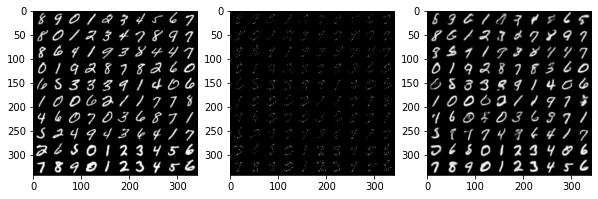

In [16]:
fig, axs = plt.subplots(figsize=(10, 30), nrows = 1, ncols = 3)
grid = make_grid(x, nrow=10).cpu()
axs[0].imshow(rearrange(grid, 'c h w -> h w c'))
grid = make_grid(x_tilde, nrow=10).cpu()
axs[1].imshow(rearrange(grid, 'c h w -> h w c'))
grid = make_grid(x_hat, nrow=10).cpu()
axs[2].imshow(rearrange(grid, 'c h w -> h w c'))

## The single test

In [18]:
config['operator_params']["operator"] = "RandomOcclude"
config["exp_params"]["batch_size"] = 100
config['estimator_params']['lambda'] = 1
config['estimator_params']['potential'] = "mse"
config['estimator_params']['mode'] = "importance_avg"
config['estimator_params']['initalisation'] = "map_posterior"
config['estimator_params']['num_steps_map_initaliser'] = 100
config['estimator_params']['step_size_map_initaliser'] = 0.1
config["estimator_params"]["noise_factor"] = 0.5
config["base_model_params"]["model_name"] = "mnist/vae/vanilla"
dm = mnist_dataloader_test(config, path=path)

In [19]:
show(config)

operator_params
    operator: RandomOcclude
    size: 13
    num_measurements: 100
estimator_params
    estimator: langevin
    burn_in: 120
    n_samples: 15
    step_size: 0.01
    mode: importance_avg
    initalisation: map_posterior
    potential: mse
    lambda: 1
    lambda_score: 1
    discriminator_base_model: mnist/gan/dcgan_spectral
    noise_factor: 0.5
    num_steps_finetune: 1
    num_samples_for_finetune: 10000
    num_steps_map_initaliser: 100
    step_size_map_initaliser: 0.1
    disc_on: False
    discrimiantor: <function <lambda> at 0x7fc8910d5f80>
base_model_params
    model_name: mnist/vae/vanilla


In [20]:
config["estimator_params"]["burn_in"] = 120
ebm = make_energy_model(config, path=path)
ebm = ebm.to("cuda")
error = []
for x, y in tqdm(dm):
    x = x.to("cuda")
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    error.append(reconstruction_error(x_hat, x))
e_x = (sum(error)/len(error)).cpu().detach()
e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
std = np.sqrt(e_x2 - (e_x)**2)
print(e_x)
print(std)

100%|██████████| 100/100 [01:05<00:00,  1.54it/s]

tensor(0.0312)
tensor(0.0031)


In [21]:
config['operator_params']["operator"] = "RandomOcclude"
config["exp_params"]["batch_size"] = 100
config['estimator_params']['lambda'] = 1
config['estimator_params']['potential'] = "mse"
config['estimator_params']['mode'] = "avg"
config['estimator_params']['initalisation'] = "map_posterior"
config['estimator_params']['num_steps_map_initaliser'] = 100
config['estimator_params']['step_size_map_initaliser'] = 0.1
config["estimator_params"]["noise_factor"] = 0.5
config["base_model_params"]["model_name"] = "mnist/vae/vanilla"
config['estimator_params']['disc_on'] = False
dm = mnist_dataloader_test(config, path=path)

In [22]:
config["estimator_params"]["burn_in"] = 120
ebm = make_energy_model(config, path=path)
ebm = ebm.to("cuda")
error = []
for x, y in tqdm(dm):
    x = x.to("cuda")
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    error.append(reconstruction_error(x_hat, x))
e_x = (sum(error)/len(error)).cpu().detach()
e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
std = np.sqrt(e_x2 - (e_x)**2)
print(e_x)
print(std)

100%|██████████| 100/100 [00:59<00:00,  1.68it/s]

tensor(0.0427)
tensor(0.0028)


In [13]:
config['operator_params']["operator"] = "RandomOcclude"
config['estimator_params']['initalisation'] = "random"
config['estimator_params']['num_steps_map_initaliser'] = 100
config['estimator_params']['step_size_map_initaliser'] = 0.1
config['estimator_params']['potential'] = "mse"
config['estimator_params']['lambda'] = 1
config['estimator_params']['mode'] = "importance_avg"
config['estimator_params']['lambda_score'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan_spectral"
config["base_model_params"]["model_name"] = "mnist/vae/vanilla"
config["estimator_params"]["num_steps_finetune"] = 1
config["estimator_params"]["num_samples_for_finetune"] = 10000
config["estimator_params"]["noise_factor"] = 0.05
config['estimator_params']['disc_on'] = True

In [14]:
show(config)

operator_params
    operator: RandomOcclude
    size: 13
    num_measurements: 100
estimator_params
    estimator: langevin
    burn_in: 120
    n_samples: 15
    step_size: 0.01
    mode: importance_avg
    initalisation: random
    potential: mse
    lambda: 1
    lambda_score: 1
    discriminator_base_model: mnist/gan/dcgan_spectral
    noise_factor: 0.05
    num_steps_finetune: 1
    num_samples_for_finetune: 10000
    num_steps_map_initaliser: 100
    step_size_map_initaliser: 0.1
    disc_on: True
    discrimiantor: <function <lambda> at 0x7f4b83fe5f80>
base_model_params
    model_name: mnist/vae/vanilla


In [16]:
config["estimator_params"]["burn_in"] = 120
ebm = make_energy_model(config, path=path)
ebm = ebm.to("cuda")
discriminator = Discriminator(config)
discriminator.load_state_dict(torch.load("non_gan_discriminator.ckpt"))
discriminator.to("cuda")
ebm.kwargs["discriminator"] = discriminator
error = []
for x, y in tqdm(dm):
    x = x.to("cuda")
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    error.append(reconstruction_error(x_hat, x))
e_x = (sum(error)/len(error)).cpu().detach()
e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
std = np.sqrt(e_x2 - (e_x)**2)
print(e_x)
print(std)

 25%|██▌       | 25/100 [00:37<01:53,  1.52s/it]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.70 GiB total capacity; 21.69 GiB already allocated; 1.69 MiB free; 22.21 GiB reserved in total by PyTorch)

## Burn-in test

In [61]:
config["exp_params"]["batch_size"] = 100
config['estimator_params']['lambda'] = 1
config['estimator_params']['potential'] = "mse"
config['estimator_params']['mode'] = "avg"
config['estimator_params']["initalisation"] = "map_posterior"
config["estimator_params"]["noise_factor"] = 0.5
config["base_model_params"]["model_name"] = "mnist/vae/vanilla"
config['estimator_params']['mode'] = "importance_avg"
dm = mnist_dataloader_test(config, path=path)

In [62]:
show(config)

operator_params
    operator: RandomOcclude
    size: 13
    num_measurements: 100
estimator_params
    estimator: langevin
    burn_in: 200
    n_samples: 15
    step_size: 0.01
    mode: importance_avg
    initalisation: map_posterior
    potential: mse
    lambda: 1
    lambda_score: 1
    discriminator_base_model: mnist/gan/dcgan_spectral
    noise_factor: 0.5
    num_steps_finetune: 1
    num_samples_for_finetune: 10000
    num_steps_map_initaliser: 100
    step_size_map_initaliser: 0.1
    disc_on: False
    discrimiantor: <function <lambda> at 0x7fc8910d5f80>
base_model_params
    model_name: mnist/vae/vanilla


In [63]:
langevin = []
error_langevin = []
for num in trange(0, 220, 20):
    config["estimator_params"]["burn_in"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    langevin.append(e_x)
    error_langevin.append(std)

100%|██████████| 11/11 [10:59<00:00, 60.00s/it]


In [56]:
config['estimator_params']["initalisation"] = "random"
config['estimator_params']['potential'] = "mse"
config['estimator_params']['mode'] = "avg"
config['estimator_params']['lambda'] = 1
config['estimator_params']['lambda_score'] = 1
config['estimator_params']["initalisation"] = "map_posterior"
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan_spectral"
config["base_model_params"]["model_name"] = "mnist/vae/vanilla"
config["estimator_params"]["num_steps_finetune"] = 1
config["estimator_params"]["num_samples_for_finetune"] = 10000
config["estimator_params"]["noise_factor"] = 0.5

In [57]:
show(config)

operator_params
    operator: RandomOcclude
    size: 13
    num_measurements: 100
estimator_params
    estimator: langevin
    burn_in: 200
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: map_posterior
    potential: mse
    lambda: 1
    lambda_score: 1
    discriminator_base_model: mnist/gan/dcgan_spectral
    noise_factor: 0.5
    num_steps_finetune: 1
    num_samples_for_finetune: 10000
    num_steps_map_initaliser: 100
    step_size_map_initaliser: 0.1
    disc_on: False
    discrimiantor: <function <lambda> at 0x7fc8910d5f80>
base_model_params
    model_name: mnist/vae/vanilla


In [58]:
dwls_est = []
error_dwls_est = []
for num in trange(0, 220, 20):
    config["estimator_params"]["burn_in"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    dwls_est.append(e_x)
    error_dwls_est.append(std)

100%|██████████| 11/11 [10:16<00:00, 56.07s/it]


In [65]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

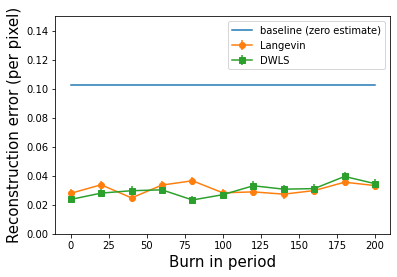

In [66]:
plt.xlabel('Burn in period', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 220, 20)), [baseline]*11)
plt.errorbar(list(range(0, 220, 20)), langevin, yerr=error_langevin, fmt='-o')
plt.errorbar(list(range(0, 220, 20)), dwls_est, yerr=error_dwls_est, fmt='-s')
plt.legend(['baseline (zero estimate)','Langevin', 'DWLS'])
plt.show()

In [67]:
dwls_est

[tensor(0.0237),
 tensor(0.0281),
 tensor(0.0297),
 tensor(0.0303),
 tensor(0.0233),
 tensor(0.0270),
 tensor(0.0331),
 tensor(0.0308),
 tensor(0.0312),
 tensor(0.0396),
 tensor(0.0346)]

In [68]:
langevin

[tensor(0.0279),
 tensor(0.0338),
 tensor(0.0248),
 tensor(0.0336),
 tensor(0.0366),
 tensor(0.0283),
 tensor(0.0289),
 tensor(0.0273),
 tensor(0.0298),
 tensor(0.0356),
 tensor(0.0333)]

In [69]:
error_langevin

[tensor(0.0026),
 tensor(0.0029),
 tensor(0.0030),
 tensor(0.0031),
 tensor(0.0029),
 tensor(0.0028),
 tensor(0.0030),
 tensor(0.0032),
 tensor(0.0031),
 tensor(0.0029),
 tensor(0.0027)]

In [70]:
error_dwls_est

[tensor(0.0025),
 tensor(0.0027),
 tensor(0.0031),
 tensor(0.0030),
 tensor(0.0025),
 tensor(0.0028),
 tensor(0.0029),
 tensor(0.0031),
 tensor(0.0028),
 tensor(0.0032),
 tensor(0.0029)]